<a href="https://colab.research.google.com/github/vsinyutsina/hft_final_qw/blob/main/%D0%9F%D1%80%D0%B8%D0%BC%D0%B5%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5_%D1%81%D0%B0%D0%BC%D1%8B%D1%85_%D0%BF%D1%80%D0%BE%D1%81%D1%82%D1%8B%D1%85_%D1%81%D1%82%D1%80%D0%B0%D1%82%D0%B5%D0%B3%D0%B8%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from math import sqrt

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
shares = {
            'Microsoft': 'MSFT',
            'Apple': 'AAPL',
            'NVIDIA': 'NVDA',
            'Amazon': 'AMZN',
            'Alphabet': 'GOOG',
            'Tesla': 'TSLA',
            'Broadcom': 'AVGO',
            'Meta': 'META',
            'Costco': 'COST',
            'Netflix': 'NFLX'
        }
crypto = {
            'Bitcoin': 'BTC',
            'Ethereum': 'ETH',
            'Tether': 'USDT',
            'Binance': 'BNB',
            'Solana': 'SOL',
            'XRP': 'XRP',
            'Cardano': 'ADA',
            'Dogecoin': 'DOGE',
            'Toncoin': 'TON'
        }

In [4]:
df_hft_old = pd.read_csv('hft_data.csv')
df_hft_first = pd.read_csv('hft_data (1).csv')
df_hft_second = pd.read_csv('hft_data_3.csv')
df_hft = pd.concat([df_hft_old, df_hft_first, df_hft_second])
df_hft.head()

,Datetime,Close,High,Low,Open,Volume,share_name,ticker_name
0,2025-02-03 14:30:00+00:00,410.720001,411.980011,409.119995,411.760010,1942143.0,Microsoft,MSFT
1,2025-02-03 14:31:00+00:00,411.290009,411.500000,410.000000,410.734985,174765.0,Microsoft,MSFT
2,2025-02-03 14:32:00+00:00,413.320007,413.320007,411.399994,411.399994,174173.0,Microsoft,MSFT
3,2025-02-03 14:33:00+00:00,412.850006,413.950012,412.850006,413.269989,162649.0,Microsoft,MSFT
4,2025-02-03 14:34:00+00:00,412.934998,413.160004,412.630005,412.804993,120189.0,Microsoft,MSFT


In [5]:
df_hft['Datetime'] = pd.to_datetime(df_hft['Datetime'])
df_hft['Datetime'] = df_hft['Datetime'].dt.tz_convert(None)

# Мини-версия предсказания

In [ ]:
import pandas as pd
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing

def train_test_series_split(df, test_size=0.2):

    train_size = int(len(series) * (1 - test_size))
    train, test = series[:train_size], series[train_size:]

    return train, test


def train_and_predict_ses(series, test_size=0.1):

    train, test = train_test_series_split(series, test_size=test_size)

    model = SimpleExpSmoothing(series)
    model_fit = model.fit(optimized=True)

    forecast = model_fit.forecast(steps=len(test))

    return model, forecast, train, test

In [6]:
# Группируем данные по ticker_name
grouped = df_hft.groupby('ticker_name')['Target']

# Создаем словарь для хранения результатов
results_ses = {}

# Итерируемся по каждой группе (акции) и обучаем модель
for ticker, series in grouped:
    print(f"Обучение модели для {ticker}...")
    series = series[~series.isna()]
    model, predictions, train, test = train_and_predict_ses(series)
    rmse = sqrt(mean_squared_error(test, predictions))
    mape = mean_absolute_percentage_error(test, predictions)
    results_ses[ticker] = {'predictions': predictions, 'rmse': rmse,
                       'mape': mape, 'model': model, 'train': train, 'test': test}
    print(f"MAPE для {ticker}: {mape:.4f}")
    print("-" * 20)

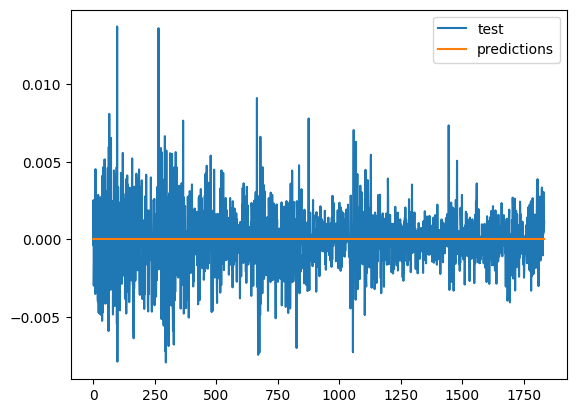

In [ ]:
import matplotlib.pyplot as plt

tsla = results_ses['TSLA']
plt.plot(tsla['test'].reset_index(drop=True))
plt.plot(tsla['predictions'].reset_index(drop=True))
plt.legend(['test', 'predictions'])
plt.show()

In [ ]:
df_result = pd.DataFrame([(ticker, result['rmse'], result['mape']) for ticker, result in results_ses.items()],
                         columns=['ticker_name', 'rmse_ses', 'mape_ses'])
df_result

,ticker_name,rmse_ses,mape_ses
0,AAPL,0.001575,1.359218e+09
1,AMZN,0.001336,5.988727e+09
2,AVGO,0.001813,3.021134e+09
3,BTC,0.000848,3.849262e+09
4,COST,0.001001,4.094575e+10
5,ETH,0.001412,6.031883e+11
6,GOOG,0.001090,8.665734e+09
7,META,0.001472,1.012082e+09
8,MSFT,0.001014,2.740629e+08
9,NFLX,0.001305,1.795367e+09


In [ ]:
def train_and_predict_hw(series, test_size=0.2):

    train, test = train_test_series_split(series, test_size=0.2)

    model = ExponentialSmoothing(series, seasonal_periods=60,
                                 trend='add', seasonal='add')  # seasonal_periods = период сезонности
    model_fit = model.fit(optimized=True)

    forecast = model_fit.forecast(steps=len(test))

    return model, forecast, train, test

In [ ]:
# Создаем словарь для хранения результатов
results_hw = {}

# Итерируемся по каждой группе (акции) и обучаем модель
for ticker, series in grouped:
    if ticker == 'USDC':
      continue
    print(f"Обучение модели для {ticker}...")
    series = series[~series.isna()]
    model, predictions, train, test = train_and_predict_hw(series)
    rmse = sqrt(mean_squared_error(test, predictions))
    mape = mean_absolute_percentage_error(test, predictions)
    results_hw[ticker] = {'predictions': predictions, 'rmse': rmse,
                       'mape': mape, 'model': model, 'train': train, 'test': test}
    print(f"MAPE для {ticker}: {mape:.4f}")

Обучение модели для AAPL...
MAPE для AAPL: 5041687924.4448
Обучение модели для AMZN...
MAPE для AMZN: 5277107368.5965
Обучение модели для AVGO...
MAPE для AVGO: 5737571616.7411
Обучение модели для BTC...
MAPE для BTC: 87079458337.2491
Обучение модели для COST...
MAPE для COST: 12575610329.1852
Обучение модели для ETH...
MAPE для ETH: 80767322912.9755
Обучение модели для GOOG...
MAPE для GOOG: 7787539617.2342
Обучение модели для META...
MAPE для META: 764837215.1737
Обучение модели для MSFT...
MAPE для MSFT: 2396018660.7865
Обучение модели для NFLX...
MAPE для NFLX: 3407812714.6442
Обучение модели для NVDA...
MAPE для NVDA: 3665845506.1723
Обучение модели для SOL...
MAPE для SOL: 1428872333629.0435
Обучение модели для TSLA...
MAPE для TSLA: 2068713541.8196


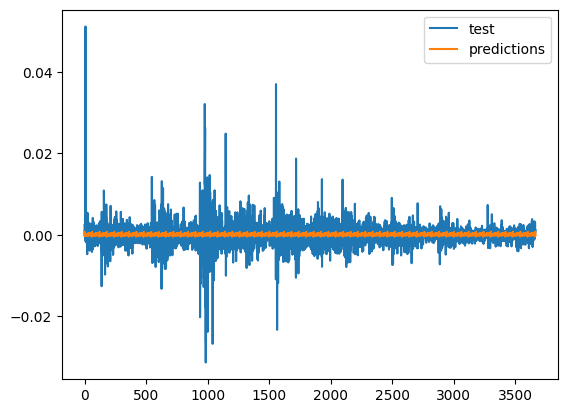

In [ ]:
import matplotlib.pyplot as plt

tsla = results_hw['TSLA']
plt.plot(tsla['test'].reset_index(drop=True))
plt.plot(tsla['predictions'].reset_index(drop=True))
plt.legend(['test', 'predictions'])
plt.show()

# Новые признаки для классического ML

In [7]:
import math

def new_time_features(data):
  data['minute'] = data.Datetime.dt.minute
  data['hour'] = data.Datetime.dt.hour
  data['day'] = data.Datetime.dt.day
  data['weekday'] = data.Datetime.dt.weekday

  d_time = [('minute', 60), ('hour', 24), ('day', 31), ('weekday', 7)]

  for col_name, period in d_time:
    data[col_name + '_sin'] = np.sin(2 * np.pi * data[col_name] / period)
    data[col_name + '_cos'] = np.cos(2 * np.pi * data[col_name] / period)
    data[col_name] = data[col_name].apply(str)

  return data


def new_price_features(data):

  close = data['Close']
  high = data['High']
  low = data['Low']
  open_price = data['Open']

  data['median_price'] = (high + low) / 2
  data['weighted_close'] = (high + low + close * 2) / 4
  data['price_range'] = (high - low)
  data['price_body'] = (close - open_price)
  data['price_body_abs'] = np.abs(close - open_price)
  data['price_body_relative'] = data['price_body']/data['price_range']

  return data


def recognize_candlestick_patterns(df):
  """Добавляет признаки для свечных паттернов."""

  close = df['Close']
  high = df['High']
  low = df['Low']
  open_price = df['Open']

  # 1. Doji
  df['is_doji'] = np.where(abs(close - open_price) <= 0.01 * (high - low), 1, 0)  # Тело очень маленькое
  # 2. Hammer (Молот)
  df['is_hammer'] = np.where(
      ((high - low) > 3 * (open_price - close)) &  # Большой нижний хвост
      ((close - low) <= 0.3 * (high - low)) &    # Маленькое тело в верхней части диапазона
      ((open_price - low) <= 0.3 * (high - low)),  # Маленькое тело в верхней части диапазона
      1, 0
  )

  # 3. Engulfing (Поглощение) - Bullish and Bearish
  df['is_bullish_engulfing'] = np.where(
      (open_price.shift(1) > close.shift(1)) &  # Предыдущая свеча медвежья
      (open_price < close) &                    # Текущая свеча бычья
      (open_price < close.shift(1)) &        # Текущая свеча открылась ниже закрытия предыдущей
      (close > open_price.shift(1)),            # Текущая свеча закрылась выше открытия предыдущей
      1, 0
  )
  df['is_bearish_engulfing'] = np.where(
      (open_price.shift(1) < close.shift(1)) &  # Предыдущая свеча бычья
      (open_price > close) &                    # Текущая свеча медвежья
      (open_price > close.shift(1)) &        # Текущая свеча открылась выше закрытия предыдущей
      (close < open_price.shift(1)),            # Текущая свеча закрылась ниже открытия предыдущей
      1, 0
  )
  # Объединим в один флаг
  df['is_engulfing'] = np.where((df['is_bullish_engulfing']==1) | (df['is_bearish_engulfing']==1),1,0)


  # 4. Morning Star / Evening Star (Упрощенная версия) - Звезда (Точнее упрощенный вариант)
  df['is_star'] = np.where(
      (abs(close.shift(1) - open_price.shift(1)) > 2 * abs(open_price.shift(1) - close.shift(1))) & # Предыдущая свеча большая
      (abs(close.shift(2) - open_price.shift(2)) > 2 * abs(open_price.shift(2) - close.shift(2))) & # Свеча перед ней тоже большая
      (abs(close - open_price) > 2 * abs(open_price - close)) & # Текущая свеча большая
      (abs(open_price.shift(1) - ((high.shift(1)+low.shift(1))/2)) < 0.01*(high.shift(1)-low.shift(1))), # промежуточная свеча это подобие доджи (значит звезда)

      1, 0
  )

  return df


def new_returns_features(data):
  lags = [1, 2, 3, 4, 14, 29, 59]

  data['simple_return'] = (data.Close - data.Close.shift(1))/data.Close.shift(1)
  data['log_return'] = np.log(data.Close/data.Close.shift(1))

  for lag in lags:
    data['log_return_lag_' + str(lag)] = data.log_return.shift(lag)
    data['simple_return_lag_' + str(lag)] = data.simple_return.shift(lag)

  return data


def new_volatility_features(data):
  """Рассчитывает различные показатели волатильности."""

  close = data['Close']
  high = data['High']
  low = data['Low']
  open_price = data['Open']
  lags = [1, 2, 3, 5, 15, 30, 60]

  data['simple_return'] = (close - close.shift(1))/close.shift(1)
  data['log_return'] = np.log(close / close.shift(1))

  for lag in lags:
    # 1. Historical Volatility (HV) - Стандартное отклонение логарифмических доходностей
    data['historical_volatility'] = data['log_return'].rolling(window=lag).std()
    # 2. Parkinson Volatility (Использует High и Low)
    data['parkinson_volatility'] = 0.361 * (np.log(high / low)**2).rolling(window=lag).sum() / lag
    # 3. Garman-Klass Volatility (Использует Open, High, Low, Close)
    log_ho = np.log(high / open_price)
    log_lo = np.log(low / open_price)
    log_co = np.log(close / open_price)
    data['garman_klass_volatility'] = (0.5 * log_ho**2 - (2*np.log(2)-1) * log_co**2).rolling(window=lag).sum() / lag
    # 4. Rogers-Satchell Volatility (Подходит для рядов с гэпами)
    log_hc = np.log(high / close.shift(1))
    log_lc = np.log(low / close.shift(1))
    data['rogers_satchell_volatility'] = (log_hc * (log_hc - log_co) + log_lc * (log_lc - log_co)).rolling(window=lag).sum() / lag

  return data


def new_statistics_features(data):
  lags = [1, 2, 3, 5, 15, 30, 60]

  for lag in lags:
    data['ratio_lag_' + str(lag)] = data.Close.shift(lag)
    data['ratio_diff_lag_' + str(lag)] = data.Close - data['ratio_lag_' + str(lag)]
    data['ratio_mean_lag_' + str(lag)] = data.Close.rolling(lag, min_periods=1).mean()
    data['ratio_diff_mean_lag_' + str(lag)] = data.Close - data['ratio_mean_lag_' + str(lag)]

  for lag in lags[3:]:
    data['ratio_max_lag_' + str(lag)] = data.Close.rolling(lag, min_periods=1).max()
    data['ratio_min_lag_' + str(lag)] = data.Close.rolling(lag, min_periods=1).min()
    data['ratio_q25_lag_' + str(lag)] = data.Close.rolling(lag, min_periods=1).quantile(0.25)
    data['ratio_q75_lag_' + str(lag)] = data.Close.rolling(lag, min_periods=1).quantile(0.75)

  return data


def new_volume_features(data):
  lags = [1, 2, 3, 5, 15]
  close = data['Close']
  high = data['High']
  low = data['Low']
  open_price = data['Open']
  volume = data['Volume']
  typical_price = (high + low + close) / 3

  data['accum_dist'] = ((close - low) - (high - close))/(high - low) * volume

  for window in lags:
    # 1. Volume-Weighted Average Price (VWAP)
    data['vwap'] = (volume * typical_price).rolling(window=window).sum() / volume.rolling(window=window).sum()
    # 2. On-Balance Volume (OBV)
    data['obv'] = np.where(close > close.shift(1), volume, np.where(close < close.shift(1), -volume, 0)).cumsum()
    # 3. Accumulation/Distribution Line (A/D)
    money_flow_multiplier = ((close - low) - (high - close)) / (high - low)
    money_flow_volume = money_flow_multiplier * volume
    data['ad_line'] = money_flow_volume.cumsum()

  return data

In [24]:
def create_all_features(df):

    df = df.groupby('ticker_name', group_keys=False).apply(new_price_features)
    df = df.groupby('ticker_name', group_keys=False).apply(new_returns_features)
    df = df.groupby('ticker_name', group_keys=False).apply(new_volatility_features)
    df = df.groupby('ticker_name', group_keys=False).apply(new_statistics_features)
    df = df.groupby('ticker_name', group_keys=False).apply(new_volume_features)

    return df

In [25]:
df_classic = df_hft.copy()
df_classic.head()

,Datetime,Close,High,Low,Open,Volume,share_name,ticker_name
0,2025-02-03 14:30:00,410.720001,411.980011,409.119995,411.760010,1942143.0,Microsoft,MSFT
1,2025-02-03 14:31:00,411.290009,411.500000,410.000000,410.734985,174765.0,Microsoft,MSFT
2,2025-02-03 14:32:00,413.320007,413.320007,411.399994,411.399994,174173.0,Microsoft,MSFT
3,2025-02-03 14:33:00,412.850006,413.950012,412.850006,413.269989,162649.0,Microsoft,MSFT
4,2025-02-03 14:34:00,412.934998,413.160004,412.630005,412.804993,120189.0,Microsoft,MSFT


In [26]:
df_classic = new_time_features(df_classic)
df_classic = recognize_candlestick_patterns(df_classic)
df_classic = create_all_features(df_classic)
df_classic.dropna(inplace=True)
df_classic.head()

,Datetime,Close,High,Low,Open,Volume,share_name,ticker_name,minute,hour,...,ratio_q25_lag_30,ratio_q75_lag_30,ratio_max_lag_60,ratio_min_lag_60,ratio_q25_lag_60,ratio_q75_lag_60,accum_dist,vwap,obv,ad_line
20,2025-02-03 14:50:00,411.769989,412.029999,411.390015,411.855011,124192.0,Microsoft,MSFT,50,14,...,392.651245,412.001259,414.470001,391.899994,393.099998,412.028809,23279.707787,400.444632,-2828722.0,-1.287675e+06
20,2025-03-03 14:50:00,394.480011,395.005005,394.429993,394.920013,41118.0,Microsoft,MSFT,50,14,...,392.651245,412.001259,414.470001,391.899994,393.099998,412.028809,-33964.576584,400.599282,-2869840.0,-1.321640e+06
20,2025-03-24 13:50:00,393.019989,393.190002,392.594208,392.628601,90804.0,Microsoft,MSFT,50,13,...,392.651245,412.001259,414.470001,391.899994,393.035004,412.028809,38981.115812,400.514733,-2960644.0,-1.282658e+06
21,2025-02-03 14:51:00,412.549988,412.690491,411.620087,411.717499,109700.0,Microsoft,MSFT,51,14,...,392.651245,412.001259,414.470001,391.899994,393.035004,412.147499,80901.208838,401.096135,-2850944.0,-1.201757e+06
21,2025-03-03 14:51:00,395.250000,395.290009,394.458008,394.458405,63313.0,Microsoft,MSFT,51,14,...,392.651245,412.001259,414.470001,391.899994,393.035004,412.147499,57223.916407,401.157480,-2914257.0,-1.144533e+06


In [27]:
df_classic.shape, df_hft.shape

((208767, 100), (221229, 8))

В зависимости от стратегии, есть разные варианты выбора таргета.

# Вариант 1.  Magnitude of Price Change (Величина изменения цены)

In [28]:
def create_target_magnitude(df, future_period=1):
    """Создает целевую переменную для величины изменения цены."""
    df['Future_Price'] = df['Close'].shift(-future_period)
    df['Target'] = (df['Future_Price'] - df['Close'])
    df = df.drop(['Future_Price'], axis=1)
    df.dropna(inplace=True)
    return df

In [29]:
df_classic = df_classic.groupby('ticker_name', group_keys=False).apply(create_target_magnitude)
df_classic.head()

,Datetime,Close,High,Low,Open,Volume,share_name,ticker_name,minute,hour,...,ratio_q75_lag_30,ratio_max_lag_60,ratio_min_lag_60,ratio_q25_lag_60,ratio_q75_lag_60,accum_dist,vwap,obv,ad_line,Target
1965,2025-03-03 14:45:00,242.705002,243.229996,242.539993,243.104996,113195.0,Apple,AAPL,45,14,...,242.836254,243.799896,218.809998,226.748756,241.689999,-59055.648828,230.016038,1815879.0,-294856.316570,-23.137100
1965,2025-03-24 13:45:00,219.567902,219.860001,219.330002,219.570007,140717.0,Apple,AAPL,45,13,...,242.836254,243.799896,218.809998,220.503754,241.689999,-14390.130247,230.016430,1675162.0,-309246.446817,8.752106
1966,2025-02-03 15:00:00,228.320007,228.824997,228.039993,228.809998,406528.0,Apple,AAPL,0,15,...,242.836254,243.799896,218.809998,220.503754,241.689999,-116507.577499,229.834740,2081690.0,-425754.024316,14.304993
1966,2025-03-03 14:46:00,242.625000,242.850006,242.429993,242.720001,106188.0,Apple,AAPL,46,14,...,242.685001,243.799896,218.809998,220.503754,241.907501,-7584.306038,229.649379,2187878.0,-433338.330354,-22.904999
1966,2025-03-24 13:46:00,219.720001,219.720001,219.250000,219.544998,111030.0,Apple,AAPL,46,13,...,242.685001,243.799896,218.809998,220.355003,241.907501,111030.000000,229.910671,2076848.0,-322308.330354,8.225006


## Линейная регрессия - бейзлайн

In [30]:
def take_first_80_percent(group):
  group = group.reset_index(drop=True)
  n = group.shape[0]
  take_count = int(n * 0.8)  # Количество строк, которые нужно взять
  group['split'] = None
  group.loc[:take_count-1, 'split'] = 'train'
  group.loc[take_count:, 'split'] = 'test'
  return group


def train_test_split_series_split(df, test_size=0.2, target_col='Target', group_col='ticker_name'):

  data = df.groupby(group_col, group_keys=False).apply(take_first_80_percent)
  train, test = data.query('split == "train"'), data.query('split == "test"')

  y_train = train[target_col]
  y_test = test[target_col]
  X_train = train.drop([target_col, 'split'], axis=1)
  X_test = test.drop([target_col, 'split'], axis=1)

  return X_train, X_test, y_train, y_test

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor

X_train, X_test, y_train, y_test = train_test_split_series_split(df_classic)

In [32]:
X_stats_train = X_train.groupby('ticker_name')['simple_return'].count().reset_index()
X_stats_test = X_test.groupby('ticker_name')['simple_return'].count().reset_index()
X_stats = X_stats_train.merge(X_stats_test, on='ticker_name')
X_stats['train_ratio'] = X_stats.simple_return_x/(X_stats.simple_return_x + X_stats.simple_return_y) * 100
X_stats['test_ratio'] = 100 - X_stats['train_ratio']

X_stats

,ticker_name,simple_return_x,simple_return_y,train_ratio,test_ratio
0,AAPL,14607,3652,79.998905,20.001095
1,AMZN,14604,3652,79.995618,20.004382
2,AVGO,14606,3652,79.997809,20.002191
3,BTC,11170,2793,79.997135,20.002865
4,COST,12495,3124,79.998720,20.001280
5,ETH,10641,2661,79.995489,20.004511
6,GOOG,14600,3651,79.995617,20.004383
7,META,14594,3649,79.997807,20.002193
8,MSFT,14600,3650,80.000000,20.000000
9,NFLX,14382,3596,79.997775,20.002225


In [33]:
# Убедитесь, что mask содержит булевы значения для числовых столбцов
numeric_features = X_train.select_dtypes(include=['number']).columns.tolist()  # Автоматический выбор числовых столбцов
categorical_features = ['ticker_name']

# Создайте трансформеры
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  # Для плотного массива

# Конфигурация ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'  # Лучше явно указать ненужные столбцы
)

# Создайте пайплайн
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regression', LinearRegression())
])

# Проверьте данные перед обучением
print("Проверка столбцов в X_train:", X_train.columns.tolist())
print("Числовые столбцы:", numeric_features)
print("Категориальные столбцы:", categorical_features)

# Запустите обучение
pipeline.fit(X_train, y_train)

Проверка столбцов в X_train: ['Datetime', 'Close', 'High', 'Low', 'Open', 'Volume', 'share_name', 'ticker_name', 'minute', 'hour', 'day', 'weekday', 'minute_sin', 'minute_cos', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'weekday_sin', 'weekday_cos', 'is_doji', 'is_hammer', 'is_bullish_engulfing', 'is_bearish_engulfing', 'is_engulfing', 'is_star', 'median_price', 'weighted_close', 'price_range', 'price_body', 'price_body_abs', 'price_body_relative', 'simple_return', 'log_return', 'log_return_lag_1', 'simple_return_lag_1', 'log_return_lag_2', 'simple_return_lag_2', 'log_return_lag_3', 'simple_return_lag_3', 'log_return_lag_4', 'simple_return_lag_4', 'log_return_lag_14', 'simple_return_lag_14', 'log_return_lag_29', 'simple_return_lag_29', 'log_return_lag_59', 'simple_return_lag_59', 'historical_volatility', 'parkinson_volatility', 'garman_klass_volatility', 'rogers_satchell_volatility', 'ratio_lag_1', 'ratio_diff_lag_1', 'ratio_mean_lag_1', 'ratio_diff_mean_lag_1', 'ratio_lag_2', 'rati

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Close', 'High', 'Low',
                                                   'Open', 'Volume',
                                                   'minute_sin', 'minute_cos',
                                                   'hour_sin', 'hour_cos',
                                                   'day_sin', 'day_cos',
                                                   'weekday_sin', 'weekday_cos',
                                                   'is_doji', 'is_hammer',
                                                   'is_bullish_engulfing',
                                                   'is_bearish_engulfing',
                                                   'is_engulfing', 'is_star',
                                                   'median_price',
                                                   'weighted_close',
                                                   'price_range', 'price_body',
                                                   'price_body_abs',
                                                   'price_body_relative',
                                                   'simple_return',
                                                   'log_return',
                                                   'log_return_lag_1',
                                                   'simple_return_lag_1',
                                                   'log_return_lag_2', ...]),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['ticker_name'])])),
                ('regression', LinearRegression())])

In [34]:
predictions = pipeline.predict(X_test)

rmse = sqrt(mean_squared_error(y_test, predictions))
mape = mean_absolute_percentage_error(y_test, predictions)

mape

15163811750380.053

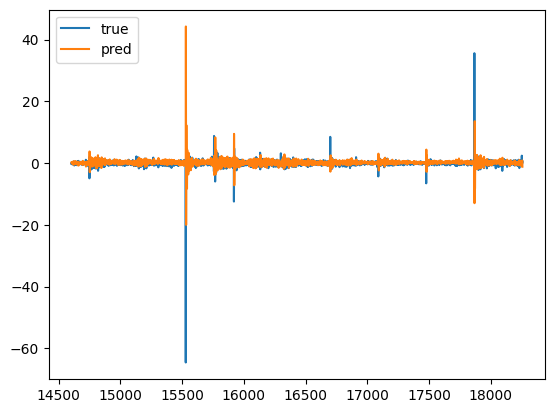

In [36]:
X_test['pred'] = predictions
X_test['true'] = y_test
tsla_true = X_test.query('ticker_name == "TSLA"').true
tsla_pred = X_test.query('ticker_name == "TSLA"').pred
plt.plot(tsla_true)
plt.plot(tsla_pred)
plt.legend(['true', 'pred'])

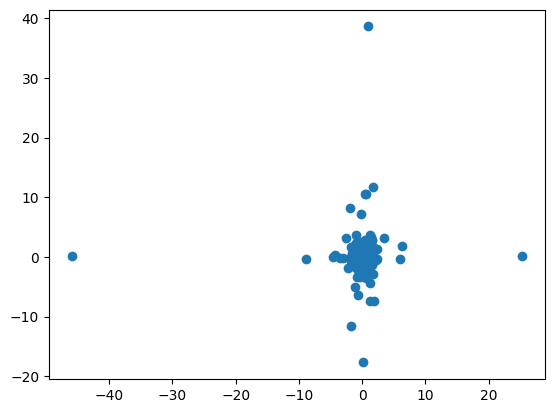

In [37]:
tsla_true_normalized = (tsla_true - tsla_true.mean())/tsla_true.std()
tsla_pred_normalized = (tsla_pred - tsla_pred.mean())/tsla_pred.std()

plt.scatter(tsla_true_normalized, tsla_pred_normalized)

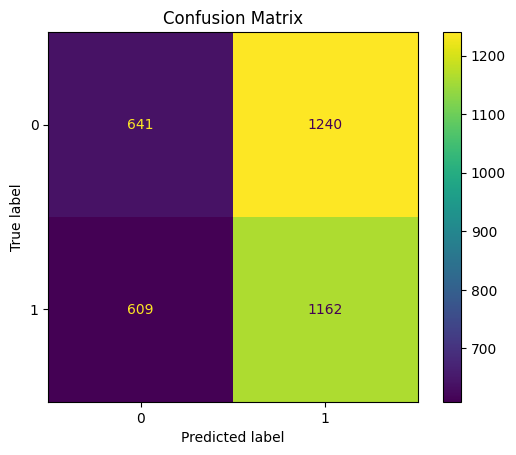

In [38]:
tsla_true_bin = tsla_true > 0
tsla_pred_bin = tsla_pred > 0

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(tsla_true_bin, tsla_pred_bin)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

In [119]:
import pandas as pd
import numpy as np

def simulate_trades_price_change(df, predictions, initial_capital=100000, commission_rate=0.001, threshold=0.01):
    """
    Симмулирует торговлю на основе предсказаний изменения цены и рассчитывает показатели.

    Args:
        df (pd.DataFrame): DataFrame с историческими данными (должен содержать 'close', 'volume' и индексы даты и тикера).
        predictions (pd.Series): Series с предсказаниями изменения цены (абсолютное изменение, например, 0.02, -0.01). Индекс должен соответствовать df.
        initial_capital (float): Начальный капитал.
        commission_rate (float): Комиссия за сделку (в долях, например, 0.001 для 0.1%).
        threshold (float): Порог изменения цены для принятия решения о покупке/продаже (например, 0.01 для 1%).

    Returns:
        pd.DataFrame: DataFrame с результатами симуляции (покупка/продажа, количество акций, цена, баланс, количество акций, общий баланс).
    """

    # 1. Инициализация
    positions = 0  # Количество акций
    cash = initial_capital
    trades = []  # Список для хранения информации о сделках
    last_action = 'none' # Сохраняем последнее действие: 'buy', 'sell', 'none'

    # 2. Итерируемся по данным, используя индексы для корректного сопоставления
    for (ticker, date), predicted_change in predictions.items():

        current_price = df.loc[(ticker, date), 'Close'].astype(np.float64)  # Получаем цену закрытия

        action = 'buy' if (predicted_change > threshold) and (last_action != 'buy') else 'hold'
        if predicted_change < -threshold and last_action != 'sell':
          action = 'sell'

        if action == 'buy':
          shares_to_buy = int(cash / current_price * (1 + commission_rate))
          if shares_to_buy > 0:
            cost = shares_to_buy * current_price * (1 + commission_rate)
            cash -= round(cost, 1)
            positions += shares_to_buy
            last_action = 'buy'
        elif (action == 'sell') and (positions > 0):
          shares_to_sell = positions * current_price * (1 - commission_rate)
          cash += round(shares_to_sell, 1)
          positions = 0
          last_action = 'sell'

        trades.append({
                'ticker': ticker,
                'date': date,
                'action': action,
                'price': current_price,
                'shares': shares_to_buy if action == "buy" else positions,
                'cash': cash,
                'positions': 0 if action == "sell" else positions,
                'total_value': cash + positions * current_price
        })

    # 4. Создаем DataFrame из списка сделок
    trades_df = pd.DataFrame(trades)
    trades_df.set_index(['ticker', 'date'], inplace=True)  # Устанавливаем мультииндекс
    return trades_df

In [ ]:
# X_test = X_test.set_index(['ticker_name', 'Datetime'])

In [120]:
cols = ['Close', 'High', 'Low', 'Open', 'Volume']

X_test_aapl = X_test.reset_index().query("ticker_name == 'AAPL'").set_index(['ticker_name', 'Datetime'])

trades_df = simulate_trades_price_change(X_test_aapl[cols], X_test_aapl['pred'],
                             initial_capital=100000,
                             commission_rate=0.001,
                             threshold=0.01)

In [123]:
import pandas as pd
import numpy as np

def analyze_trades(trades_df, initial_capital=100000):
    """
    Анализирует результаты симуляции торговли и рассчитывает показатели прибыльности.

    Args:
        trades_df (pd.DataFrame): DataFrame с результатами симуляции (возвращенный функцией simulate_trades).
        initial_capital (float): Начальный капитал.

    Returns:
        dict: Словарь с показателями прибыльности.
    """

    # 1. Рассчитываем прибыль/убыток по каждой сделке
    trades_df['trade_profit'] = 0.0  # Инициализируем столбец

    # Цикл по каждой строке, вычисляем профит и помещаем его в колонку trade_profit
    for i in range(1, len(trades_df)):
        previous_total_value = trades_df['total_value'].iloc[i-1]
        current_total_value = trades_df['total_value'].iloc[i]

        trade_profit = current_total_value - previous_total_value
        trades_df['trade_profit'].iloc[i] = trade_profit

    # 2. Рассчитываем кумулятивную прибыль
    trades_df['cumulative_profit'] = trades_df['trade_profit'].cumsum()

    # 3. Рассчитываем общий доход
    total_profit = trades_df['cumulative_profit'].iloc[-1]

    # 4. Рассчитываем процентную доходность
    total_return = (total_profit / initial_capital) * 100

    # 5. Рассчитываем максимальную просадку (Maximum Drawdown)
    # Считаем кумулятивную максимальную прибыль
    trades_df['cumulative_max'] = trades_df['total_value'].cummax()
    # Просадка - это разница между кумулятивной максимальной прибылью и текущей стоимостью
    trades_df['drawdown'] = trades_df['cumulative_max'] - trades_df['total_value']
    # Максимальная просадка - это максимальное значение просадки
    max_drawdown = trades_df['drawdown'].max()

    # 6. Дополнительные метрики (при желании)
    num_winning_trades = len(trades_df[trades_df['trade_profit'] > 0])
    num_losing_trades = len(trades_df[trades_df['trade_profit'] < 0])
    win_rate = (num_winning_trades / (num_winning_trades + num_losing_trades)) * 100 if (num_winning_trades + num_losing_trades) > 0 else 0

    # 7. Собираем результаты в словарь
    analysis_results = {
        'Total Profit': total_profit,
        'Total Return (%)': total_return,
        'Maximum Drawdown': max_drawdown,
        'Win Rate (%)': win_rate,
        'Number of Winning Trades': num_winning_trades,
        'Number of Losing Trades': num_losing_trades
    }

    return analysis_results

In [124]:
analysis_results = analyze_trades(trades_df)

In [125]:
for metric, value in analysis_results.items():
    print(f"{metric}: {value:.2f}")

Total Profit: 388046335076041201222209840731566520356840157478912.00
Total Return (%): 388046335076041233025028099257385745106130173952.00
Maximum Drawdown: 215800407928338324307211603990456396192705805287424.00
Win Rate (%): 38.47
Number of Winning Trades: 1013.00
Number of Losing Trades: 1620.00


# Черновик

In [ ]:
import pandas as pd
import numpy as np

def simulate_trades(df, predictions, initial_capital=100000, commission_rate=0.001):
    """
    Симмулирует торговлю на основе предсказаний и рассчитывает показатели.

    Args:
        df (pd.DataFrame): DataFrame с историческими данными (должен содержать 'close', 'volume' и индексы даты и тикера).
        predictions (pd.Series): Series с предсказаниями (1 - купить, -1 - продать, 0 - держать). Индекс должен соответствовать df.
        initial_capital (float): Начальный капитал.
        commission_rate (float): Комиссия за сделку (в долях, например, 0.001 для 0.1%).

    Returns:
        pd.DataFrame: DataFrame с результатами симуляции (покупка/продажа, количество акций, цена, баланс, количество акций, общий баланс).
    """

    # 1. Инициализация
    positions = 0  # Количество акций
    cash = initial_capital
    trades = []  # Список для хранения информации о сделках
    last_prediction = 0  # Сохраняем предыдущее предсказание для исключения повторных сигналов

    # 2. Итерируемся по данным, используя индексы для корректного сопоставления
    for (ticker, date), prediction in predictions.items():
        try:
            current_price = df.loc[(ticker, date), 'close']  # Получаем цену закрытия
            volume = df.loc[(ticker, date), 'volume'] # Получаем объем
        except KeyError:
            # Если данных о цене или объеме нет, пропускаем
            print(f"Пропуск данных для {ticker} {date} (нет цены или объема).")
            continue

        # 3. Определяем действия (если предсказание отличается от предыдущего)
        if prediction != last_prediction:
            if prediction == 1:  # Купить
                # Покупаем акции (максимум, на что хватает денег)
                shares_to_buy = int(cash / (current_price * (1 + commission_rate)))  # Учитываем комиссию
                if shares_to_buy > 0:
                    cost = shares_to_buy * current_price * (1 + commission_rate)
                    cash -= cost
                    positions += shares_to_buy
                    trades.append({
                        'ticker': ticker,
                        'date': date,
                        'action': 'buy',
                        'price': current_price,
                        'shares': shares_to_buy,
                        'cash': cash,
                        'positions': positions,
                        'total_value': cash + positions * current_price
                    })
            elif prediction == -1:  # Продать
                if positions > 0:  # Продаем только если есть акции
                    sell_value = positions * current_price * (1 - commission_rate)  # Учитываем комиссию
                    cash += sell_value
                    trades.append({
                        'ticker': ticker,
                        'date': date,
                        'action': 'sell',
                        'price': current_price,
                        'shares': positions,
                        'cash': cash,
                        'positions': 0,
                        'total_value': cash  # Общий баланс - только наличные
                    })
                    positions = 0 # Обнуляем количество акций
            last_prediction = prediction # Обновляем последнее предсказание

            elif prediction == 0:
                last_prediction = 0
        # 4.  Если предсказание равно 0 (держать) и есть открытые позиции,  обновляем общий баланс
        elif positions > 0:
                trades.append({
                    'ticker': ticker,
                    'date': date,
                    'action': 'hold',
                    'price': current_price,
                    'shares': positions,
                    'cash': cash,
                    'positions': positions,
                    'total_value': cash + positions * current_price
                })
        else: # если позиций нет, и предсказание "держать" - ничего не делаем

            trades.append({
                'ticker': ticker,
                'date': date,
                'action': 'hold',
                'price': current_price,
                'shares': 0,
                'cash': cash,
                'positions': 0,
                'total_value': cash
            })
        #else: #Если предсказание равно предыдущему, ничего не делаем
    # 5.  Создаем DataFrame из списка сделок
    trades_df = pd.DataFrame(trades)
    trades_df.set_index(['ticker', 'date'], inplace=True) # Устанавливаем мультииндекс
    return trades_df

In [ ]:
# 3. Определяем действия
        # if predicted_change > threshold and last_action != 'buy':  # Купить, если предсказанное изменение выше порога
        #     # Покупаем акции (максимум, на что хватает денег)
        #     shares_to_buy = int(cash / (current_price * (1 + commission_rate)))  # Учитываем комиссию
        #     if shares_to_buy > 0:
        #         cost = shares_to_buy * current_price * (1 + commission_rate)
        #         cash -= round(cost, 2)
        #         positions += shares_to_buy
        #         trades.append({
        #             'ticker': ticker,
        #             'date': date,
        #             'action': 'buy',
        #             'price': current_price,
        #             'shares': shares_to_buy,
        #             'cash': cash,
        #             'positions': positions,
        #             'total_value': cash + positions * current_price
        #         })
        #         last_action = 'buy'
        # elif predicted_change < -threshold and last_action != 'sell':  # Продать, если предсказанное изменение ниже порога
        #     if positions > 0:  # Продаем только если есть акции
        #         sell_value = positions * current_price * (1 - commission_rate)  # Учитываем комиссию
        #         cash += round(sell_value, 2)
        #         trades.append({
        #             'ticker': ticker,
        #             'date': date,
        #             'action': 'sell',
        #             'price': current_price,
        #             'shares': positions,
        #             'cash': cash,
        #             'positions': 0,
        #             'total_value': cash  # Общий баланс - только наличные
        #         })
        #         positions = 0
        #         last_action = 'sell'
        # else:  # Держать
        #     trades.append({
        #         'ticker': ticker,
        #         'date': date,
        #         'action': 'hold',
        #         'price': current_price,
        #         'shares': positions,
        #         'cash': cash,
        #         'positions': positions,
        #         'total_value': cash + positions * current_price
        #     })

## Градиентный бустинг

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Убедитесь, что mask содержит булевы значения для числовых столбцов
numeric_features = X_train.select_dtypes(include=['number']).columns.tolist()  # Автоматический выбор числовых столбцов
categorical_features = ['ticker_name']

# Создайте трансформеры
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  # Для плотного массива

# Конфигурация ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'  # Лучше явно указать ненужные столбцы
)

# Создайте пайплайн
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regression', GradientBoostingRegressor(random_state=42))
])

# Проверьте данные перед обучением
print("Проверка столбцов в X_train:", X_train.columns.tolist())
print("Числовые столбцы:", numeric_features)
print("Категориальные столбцы:", categorical_features)

# Запустите обучение
pipeline.fit(X_train, y_train)

Проверка столбцов в X_train: ['Datetime', 'Close', 'High', 'Low', 'Open', 'Volume', 'share_name', 'ticker_name', 'Returns', 'minute', 'hour', 'day', 'weekday', 'minute_sin', 'minute_cos', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'weekday_sin', 'weekday_cos', 'ratio_lag_1', 'ratio_diff_lag_1', 'ratio_mean_lag_1', 'ratio_diff_mean_lag_1', 'ratio_exp_mean_lag_1', 'ratio_lag_2', 'ratio_diff_lag_2', 'ratio_mean_lag_2', 'ratio_diff_mean_lag_2', 'ratio_exp_mean_lag_2', 'ratio_lag_3', 'ratio_diff_lag_3', 'ratio_mean_lag_3', 'ratio_diff_mean_lag_3', 'ratio_exp_mean_lag_3', 'ratio_lag_4', 'ratio_diff_lag_4', 'ratio_mean_lag_4', 'ratio_diff_mean_lag_4', 'ratio_exp_mean_lag_4', 'ratio_lag_14', 'ratio_diff_lag_14', 'ratio_mean_lag_14', 'ratio_diff_mean_lag_14', 'ratio_exp_mean_lag_14', 'ratio_lag_29', 'ratio_diff_lag_29', 'ratio_mean_lag_29', 'ratio_diff_mean_lag_29', 'ratio_exp_mean_lag_29', 'ratio_lag_59', 'ratio_diff_lag_59', 'ratio_mean_lag_59', 'ratio_diff_mean_lag_59', 'ratio_exp_mean_la

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Close', 'High', 'Low',
                                                   'Open', 'Volume', 'Returns',
                                                   'minute_sin', 'minute_cos',
                                                   'hour_sin', 'hour_cos',
                                                   'day_sin', 'day_cos',
                                                   'weekday_sin', 'weekday_cos',
                                                   'ratio_lag_1',
                                                   'ratio_diff_lag_1',
                                                   'ratio_mean_lag_1',
                                                   'ratio_diff_mean_lag_1',
                                                   'ratio_exp_mean_lag_1',
                                                   'ratio_lag_2',
                                                   'ratio_diff_lag_2',
                                                   'ratio_mean_lag_2',
                                                   'ratio_diff_mean_lag_2',
                                                   'ratio_exp_mean_lag_2',
                                                   'ratio_lag_3',
                                                   'ratio_diff_lag_3',
                                                   'ratio_mean_lag_3',
                                                   'ratio_diff_mean_lag_3',
                                                   'ratio_exp_mean_lag_3',
                                                   'ratio_lag_4', ...]),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['ticker_name'])])),
                ('regression', GradientBoostingRegressor(random_state=42))])

In [ ]:
predictions = pipeline.predict(X_test)

rmse = sqrt(mean_squared_error(y_test, predictions))
mape = mean_absolute_percentage_error(y_test, predictions)

mape

449807357859.28265

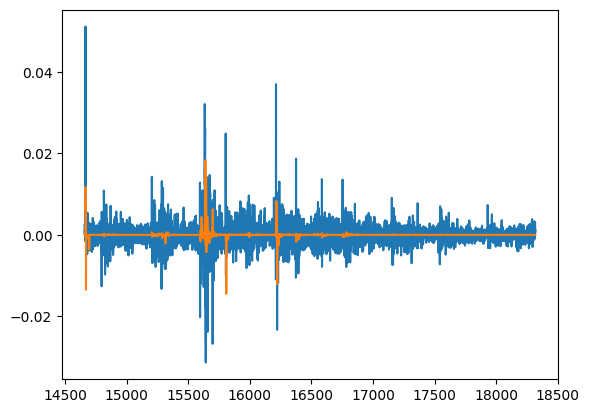

In [ ]:
import matplotlib.pyplot as plt

X_test['pred'] = predictions
X_test['true'] = y_test
tsla_pred = X_test.query('ticker_name == "TSLA"').pred
tsla_true = X_test.query('ticker_name == "TSLA"').true
plt.plot(tsla_true)
plt.plot(tsla_pred)

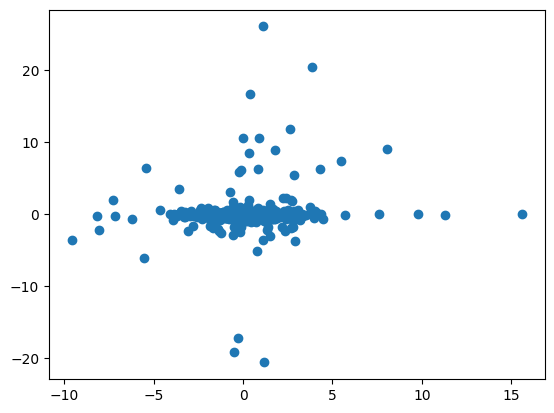

In [ ]:
tsla_true_normalized = (tsla_true - tsla_true.mean())/tsla_true.std()
tsla_pred_normalized = (tsla_pred - tsla_pred.mean())/tsla_pred.std()

plt.scatter(tsla_true_normalized, tsla_pred_normalized)

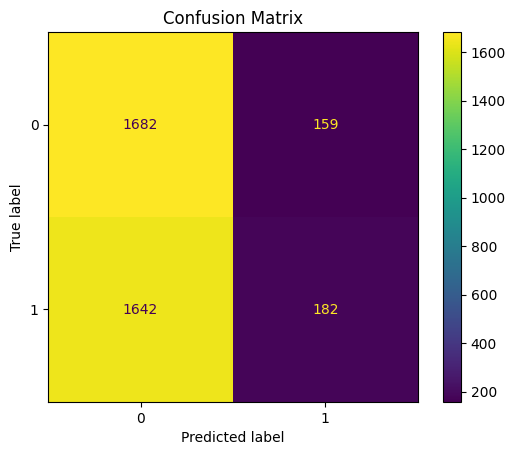

In [ ]:
tsla_true_bin = tsla_true > 0
tsla_pred_bin = tsla_pred > 0

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(tsla_true_bin, tsla_pred_bin)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

# Стратегии

In [ ]:
import datetime
import random

class MarketMaker:
    def __init__(self, asset, initial_bid, initial_ask, prediction_model):  # Добавлен prediction_model
        self.asset = asset
        self.bid = initial_bid
        self.ask = initial_ask
        self.inventory = 0  #  Начальное количество актива на балансе
        self.prediction_model = prediction_model
        self.spread = 0.05 #Разница между бид и аск
        self.threshold = 0.01

    def adjust_quotes(self, market_price):
        """Корректирует цены бид и аск на основе предсказания."""
        prediction = self.predict_price_direction(market_price)

        if prediction == "up":
            self.bid = market_price - self.spread + self.threshold
            self.ask = market_price + self.spread + self.threshold
        elif prediction == "down":
            self.bid = market_price - self.spread - self.threshold
            self.ask = market_price + self.spread - self.threshold
        else:
            # Нейтральное предсказание - поддерживаем текущий спред
            self.bid = market_price - self.spread
            self.ask = market_price + self.spread

        print(f"{datetime.datetime.now()}: New bid: {self.bid}, new ask: {self.ask}")
        # Здесь должен быть код для отправки новых ордеров на биржу.


    def predict_price_direction(self, market_price):
        """Использует модель предсказания для определения направления цены."""
        #  Здесь должна быть логика использования вашей модели self.prediction_model
        #  В этом примере мы просто возвращаем случайное направление.
        #  В реальной системе это будет вызов вашей обученной модели.
        prediction = self.prediction_model.predict([[market_price]])[0]
        if prediction == 1:
          return "up"
        elif prediction == 0:
          return "down"
        else:
          return "neutral"

In [ ]:
# Пример использования:
if __name__ == '__main__':
    #Инициализируем модель
    from sklearn.linear_model import LogisticRegression
    prediction_model = LogisticRegression()
    #Обучим модель на исторических данных
    # X - цена, y - 1 если цена выросла, 0 если упала
    X = [[100],[101],[102],[99]]
    y = [1,1,0,0]
    prediction_model.fit(X,y)

    market_maker = MarketMaker("AAPL", 150.00, 150.10, prediction_model)
    market_price = 150.05

    market_maker.adjust_quotes(market_price)